#  "House Prices - Advanced Regression Techniques"

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.offsetbox import AnchoredText

sns.set_style("darkgrid")
sns.set_palette("deep")
# Various notebook related imports
import warnings
warnings.filterwarnings('ignore')

### Extract

First read in the data from the training and unlabeled sets to get an overview

In [3]:

df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
print("train size: ", df.shape, "test size: ", df_test.shape)
df

train size:  (1460, 81) test size:  (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


No apparent issues reading in the csv files using the default settings.

- The train and test sets have 1460 and 1459 examples, respectively

- There are 79 features, divided between continous (e.g. `LotArea`), numerical categorical columns (e.g. `MoSold` / Month Sold) and string categorical columns (e.g. `MSZoning` / Zoning Classification)

- There is a single continous target variable `SalePrice` in the training set.

- There are null values in the data set (see `Alley`)

The first `Id` column is the primary key, which we will set as the index of the dataframe.

In [4]:
df.set_index("Id", inplace=True)
df_test.set_index("Id", inplace=True)

Next, have a look at the quality of the dataset by comparing the relative percent of null values in the train and unlabeled sets

In [6]:
na1 = df.isna().sum() / df.shape[0] * 100
na2 = df_test.isna().sum() / df_test.shape[0] * 100
na = pd.DataFrame({"train" : na1, "test" : na2})
na = na[na>0].dropna(how="all")
print("number of columns with null values: ", na.shape[0])

na.sort_values(by="train", ascending=False)

number of columns with null values:  34


,train,test
PoolQC,99.520548,99.794380
MiscFeature,96.301370,96.504455
Alley,93.767123,92.666210
Fence,80.753425,80.123372
FireplaceQu,47.260274,50.034270
LotFrontage,17.739726,15.558602
GarageFinish,5.547945,5.346127
GarageQual,5.547945,5.346127
GarageType,5.547945,5.209047
GarageYrBlt,5.547945,5.346127


34 out of the 79 columns have null values across the train/unlabeled sets. Following `data_description.txt`, however, for the most part the null values signify valuable information rather than missing data. For example, `PoolQC` indicates that >99.5% of the sold houses did not have pools.

Otherwise, there are few missing values overall. Only `LotFrontage` (linear feet of street connected to property) has a significant amount (~18%). To account for this we can impute the values based on similar houses, based on the Neighborhood and Zoning type.

## Target Analysis

Now we can have a look at the distribution of the target variable. Ideally for regression tasks we are looking for a normal distribution. A skewed distribution is equivalent to misbalanced classes in classification tasks.

Target distribution skew:  1.8828757597682129


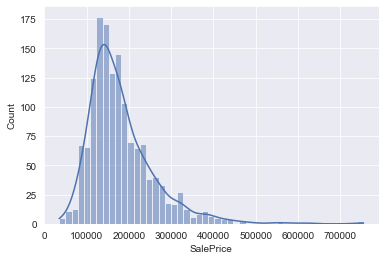

In [7]:
target = "SalePrice"
sns.histplot(df[target], kde=True)

print("Target distribution skew: ", df[target].skew())

The distribution is quite skewed. A simple fix is to apply a function to deskew the dataset. To keep the model explainable a simple transformation is prefered, such as a logarithmic function...

Log(Target) skew:  0.12133506220520406


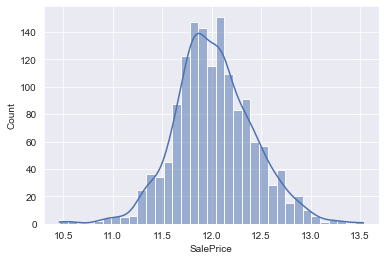

In [9]:
sns.histplot(np.log(df[target]), kde=True)
print("Log(Target) skew: ", np.log(df[target]).skew())

Thats better. To account for the skewness the model pipeline will include the `TransformedTargetRegressor` function that applies a function to the target data on input (`np.log`) and an inverse function (`np.exp`) for predictions

# Feature Selection and Engineering

To investigate potential features, we can divide up the columns into the different types, based on their data type and the information in `data_description.txt`

In [10]:
cat_cols = df.select_dtypes("object").columns.tolist()
num_cols = df.select_dtypes("number").columns.tolist()[:-1]  # remove SalePrice from list

bivariate_cols = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "MiscVal", "PoolArea"
]

num_cat_cols = [c for c in num_cols if c not in bivariate_cols]

## Bivariate Columns

First we can look at the continuous variables...
1. As a function of SalePrice. We're looking for a strong linear positive or negative linear relationship
2. Study the distribution with a histogram, looking for skews in the data.

For the histogram we'll compare with and without outliers (zeros and values > 99th percentile)

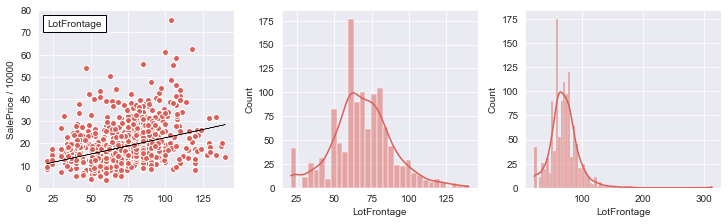

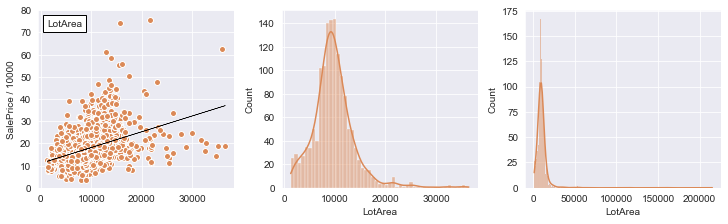

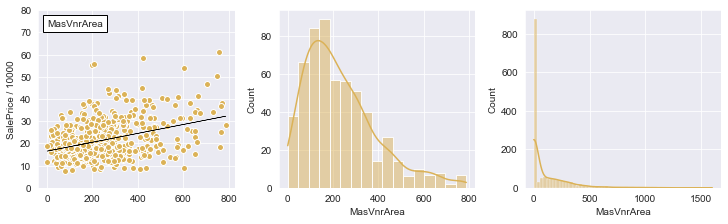

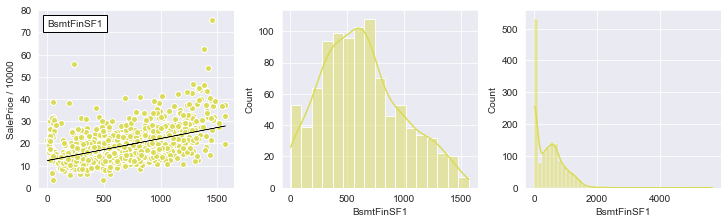

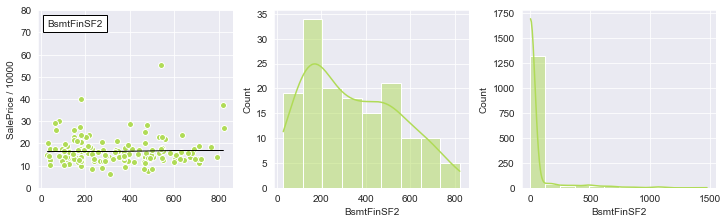

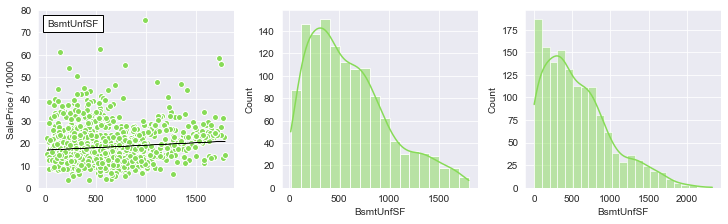

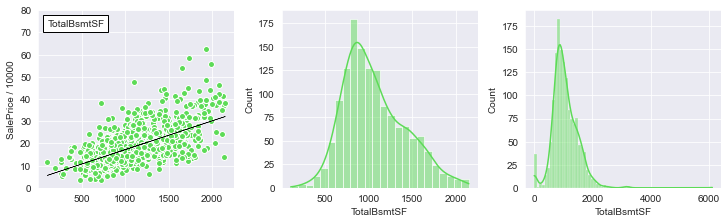

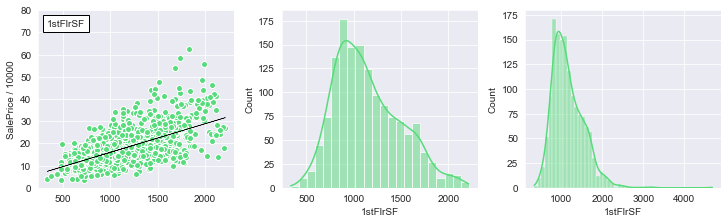

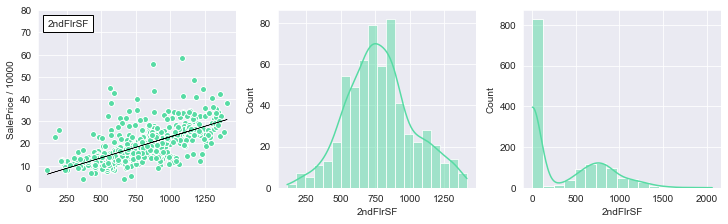

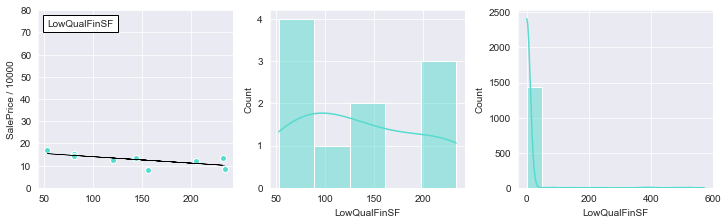

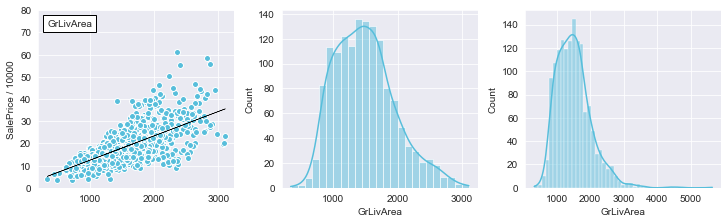

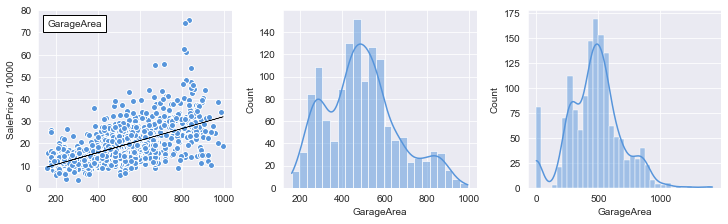

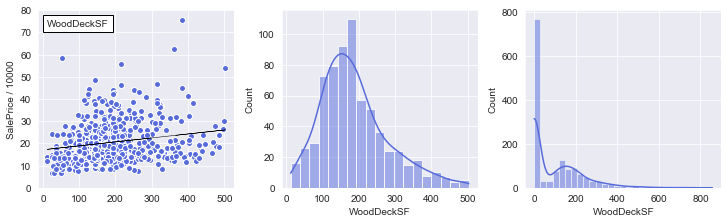

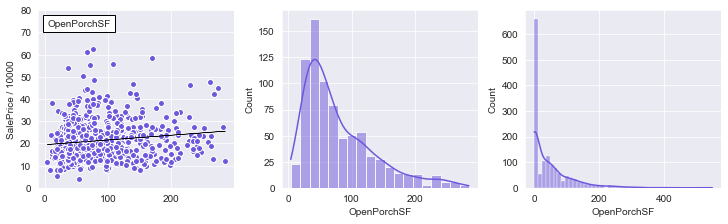

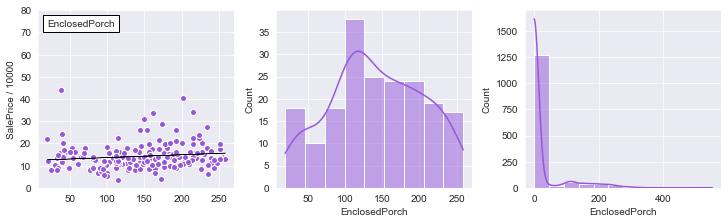

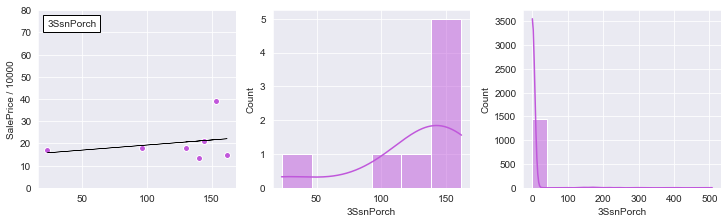

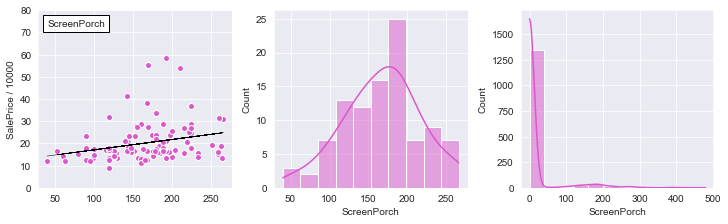

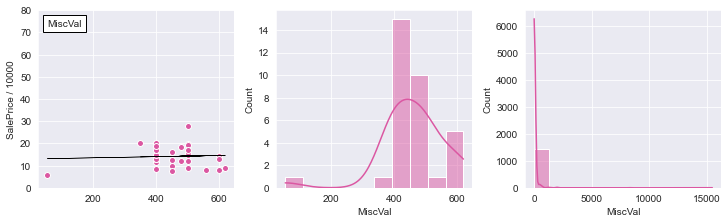

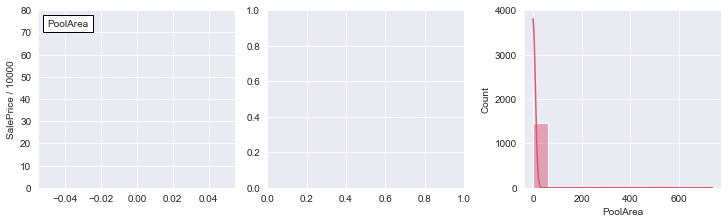

In [11]:
def plot_bivariate(cols, df=df, target="SalePrice"):
    colors = sns.color_palette("hls", len(cols))
    for col, c in zip(cols, colors):
        fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
        df1 = df.loc[(df[col] > 0) & (df[col] < df[col].quantile(0.99))]
        x, y = df1[col], df1[target]/10000
        
        ax1.plot(x, y, "o", color=c, mec="w")
        try:
            lin_model = np.poly1d(np.polyfit(x, y, 1))
            ax1.plot(x, lin_model(x), color="k", lw=0.5)
        except TypeError:
            pass
        ax1.add_artist(AnchoredText(col, loc=2))
        ax1.set_ylabel("SalePrice / 10000")
        ax1.set_ylim(0, 80)
        
        sns.histplot(df1[col], color=c, kde=True, ax=ax2)
        sns.histplot(df[col], color=c, kde=True, ax=ax3)

plot_bivariate(bivariate_cols)

From here we can select the columns that show a clear relationship and suitable distribution.
- GrLivArea has a clear mostly linear relationship
- Some of the features have many zero values, indicating that most houses lack that feature (e.g. no pool)

It appears that many of these distributions are skewed, similar to SalePrice. As a result the model will tend to fit to the lower price range where the majority of sold houses lie. We can attempt to correct this by applying a logarithmic function in the feature engineering stage.

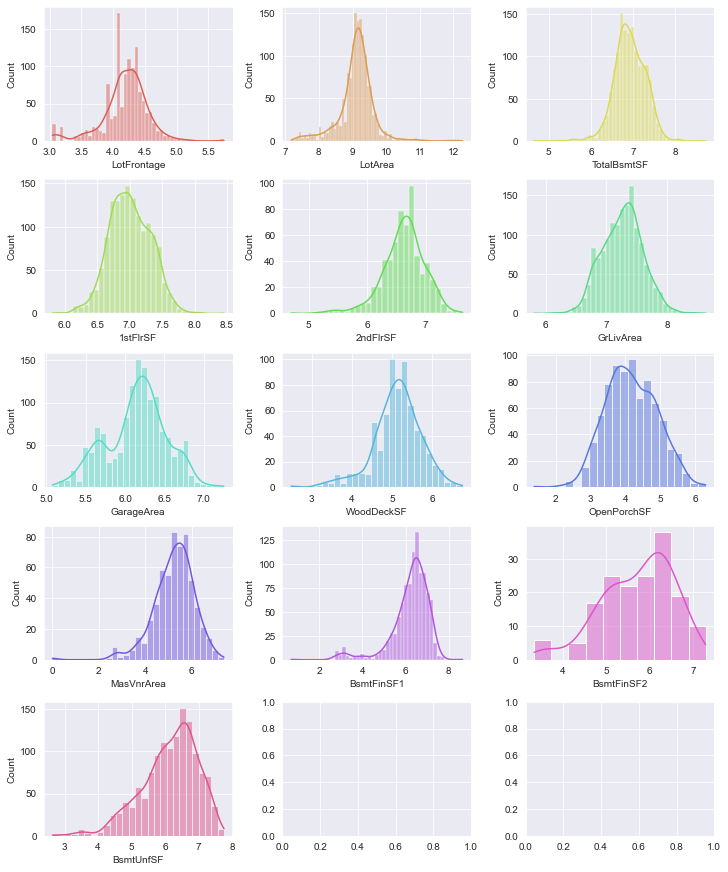

In [12]:
bivariate_cols = [
    "LotFrontage", "LotArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
    "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "MasVnrArea",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"
]

df_skew = np.log(df[bivariate_cols].copy())
df_skew[df_skew < 0] = np.nan  # mask zero values

fig, ax = plt.subplots(5, 3, figsize=(10, 12), constrained_layout=True)
colors = sns.color_palette("hls", len(bivariate_cols))
ax = ax.flatten()
for ax, col, c in zip(ax, bivariate_cols, colors):
    sns.histplot(df_skew[col], ax=ax, color=c, kde=True)

Overall the logarithmic transformation does a relatively good job across the continous features selected.

BsmtFinSF2 is borderline, but based on model iteration its inclusion improves model performance.

## Numerical Categorical Columns

Now we can have a look at the numerical categorical columns by...
1. Grouping categories, making sure to include null values as a separate category (`dropna=False`)
2. Plot category counts in a pie chart
3. Use Boxplots to check the distribution of SalePrice in each category
4. Plot the mean SalePrice of each category in a bar chart.

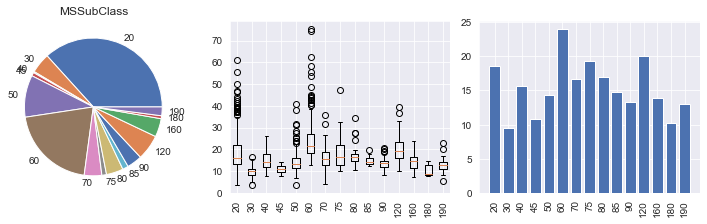

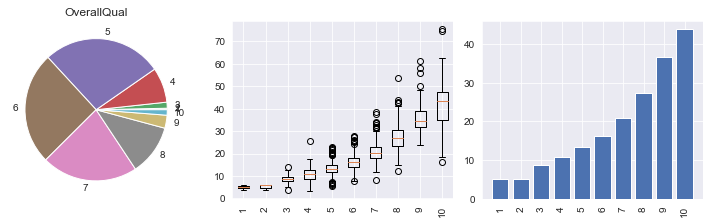

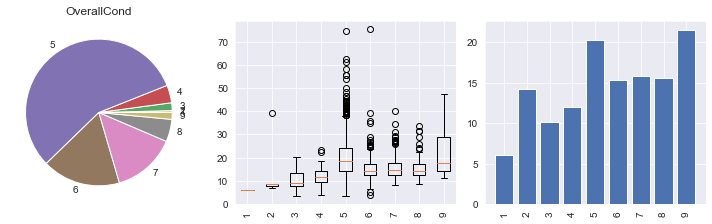

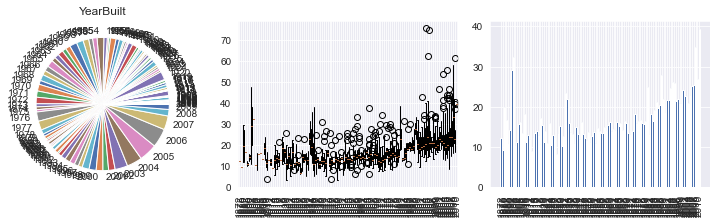

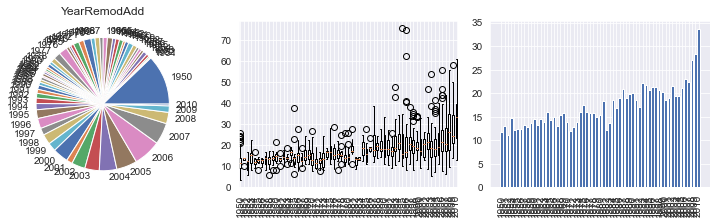

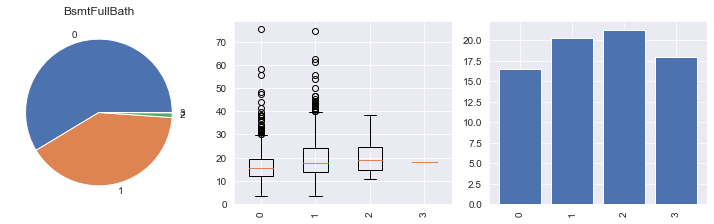

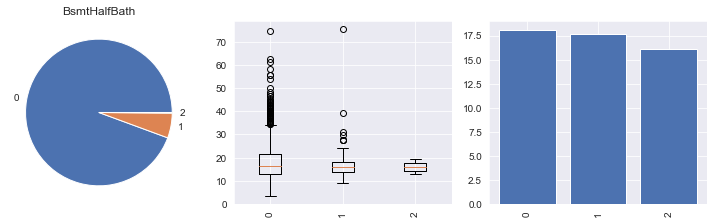

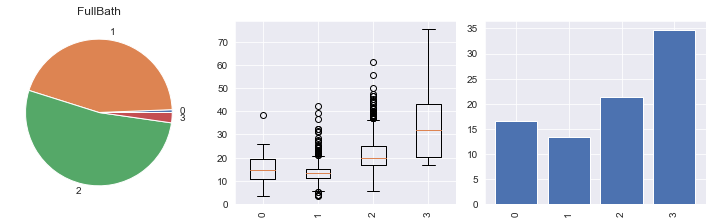

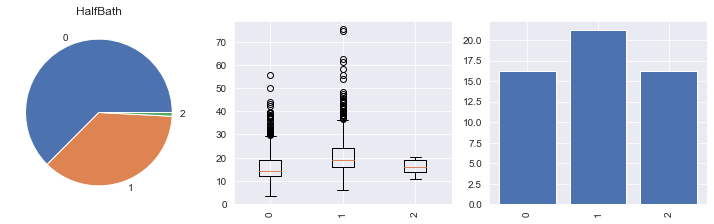

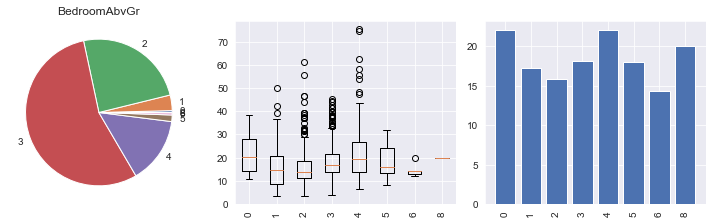

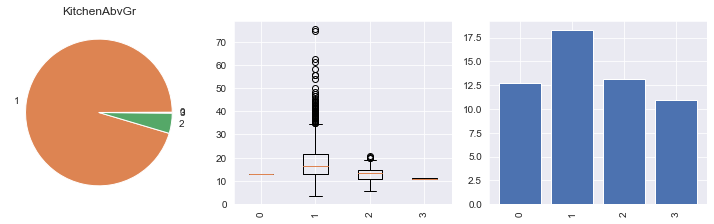

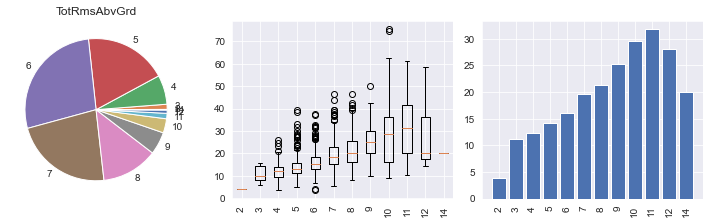

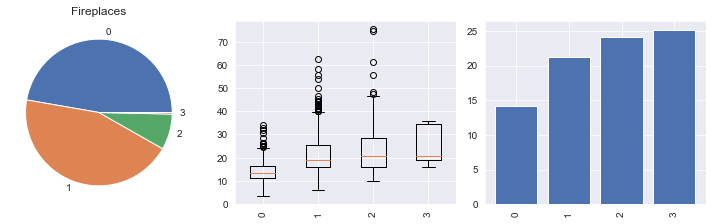

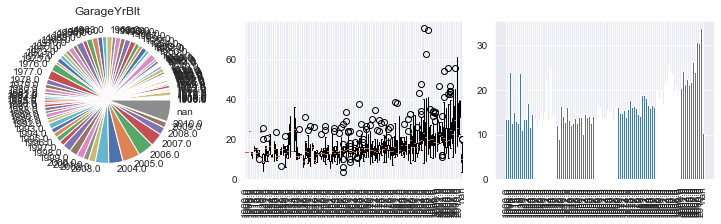

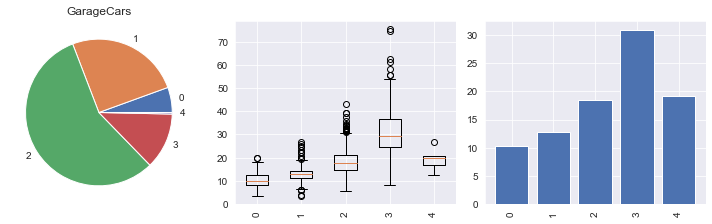

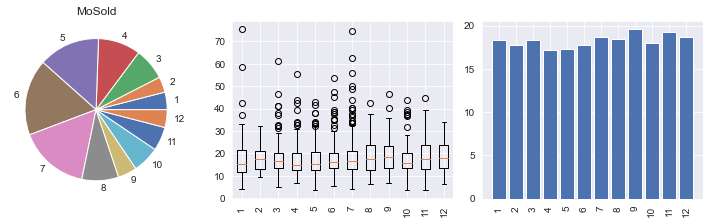

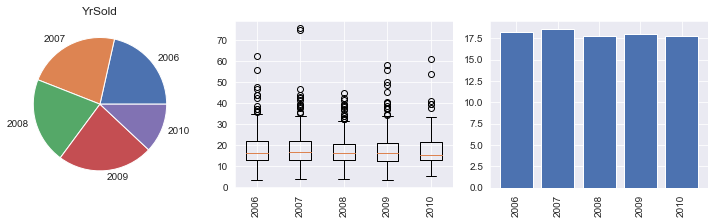

In [13]:
def plot_cat(cols, sort=True, df=df):
    colors = sns.color_palette("hls", len(cols))
    for n, c in zip(cols, colors):
        fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
        g = df.groupby(n, dropna=False)["SalePrice"]
        d = [a for a in g]
        g = g.agg(["count", "mean"])
        if sort:
            d.sort(key = lambda x: x[1].mean())
            g = g.sort_values(by="mean")
        data = [x[1]/10000 for x in d]
        labels = [x[0] for x in d]
        ax1.pie(g["count"], labels=g.index) #, autopct="%.1f%%")        
        ax2.boxplot(data)
        ax1.set_title(n)
        x = np.arange(1, g.shape[0]+1)
        ax2.set_xticks(x)
        ax2.set_xticklabels(labels, rotation=90)
        ax3.bar(x, g["mean"]/10000)
        ax3.set_xticks(x)
        ax3.set_xticklabels(labels, rotation=90)

plot_cat(num_cat_cols, sort=False)

Via this approach we can select appropriate columns and feature engineering approaches...
- MSSubClass, MoSold, YrSold and the Year columns are not numerical columns and should treated separately.
- MoSold / YrSold don't show any real relationship with SalePrice
- OverallQuality shows a very clear trend, while the OverallCondition is less clear.
- The distribution of examples in each category is generally not very consistent across the features. This can have a negative influence on the performance of the regressor.


In [14]:
num_cat_cols = [
    "OverallQual", "OverallCond", "FullBath", "HalfBath", "Fireplaces",
    "GarageCars", "TotRmsAbvGrd", "BedroomAbvGr", "KitchenAbvGr",
    "BsmtFullBath", "BsmtHalfBath"
]

## Year Columns

The year columns show pretty clear correlations with SalePrice, but year by year the data is quite noisy. To account for this we can bin the data by decade and make a cutoff for the very old houses.

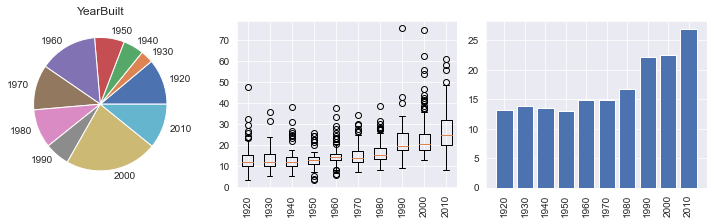

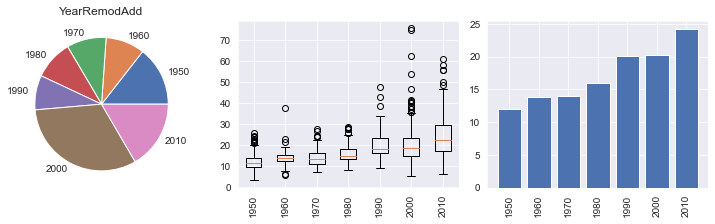

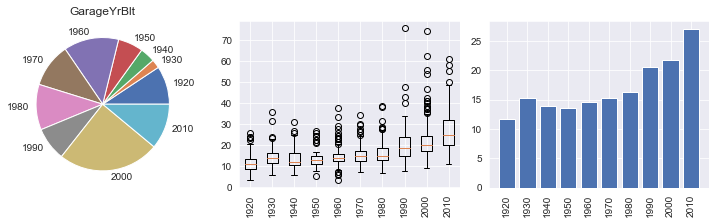

In [15]:
year_cols = ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]
df_year = df[["SalePrice"] + year_cols].copy()
for col in year_cols:
    df_year[col] = df_year[col].fillna(0)
    df_year[col] = df_year[col].apply(lambda x: int(10 * np.round(float(x)/10)))

df_year.loc[df_year["YearBuilt"] < 1920, "YearBuilt"] = 1920
df_year.loc[df_year["GarageYrBlt"] < 1920, "GarageYrBlt"] = 1920

plot_cat(year_cols, df=df_year, sort=False)

## Categorical Columns

We can now check the categorical columns, with categories sorted by mean SalePrice

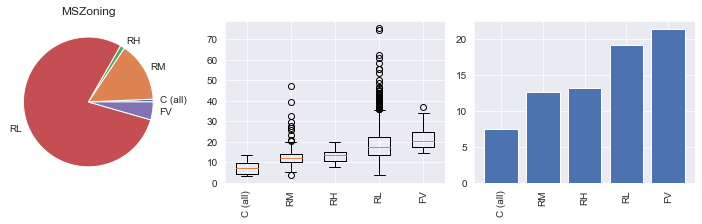

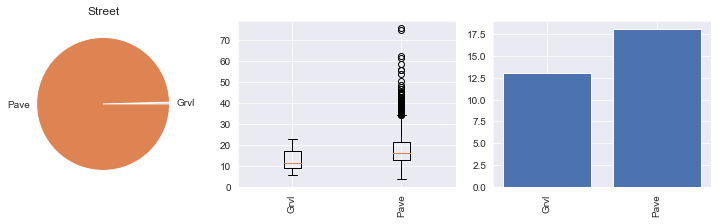

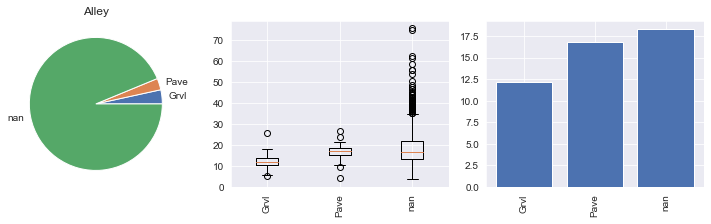

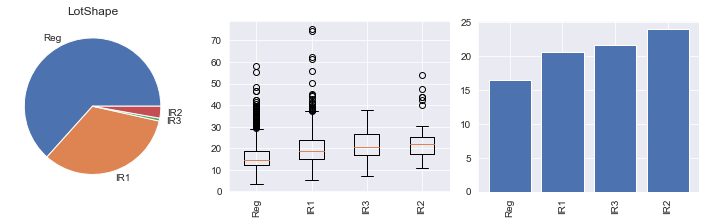

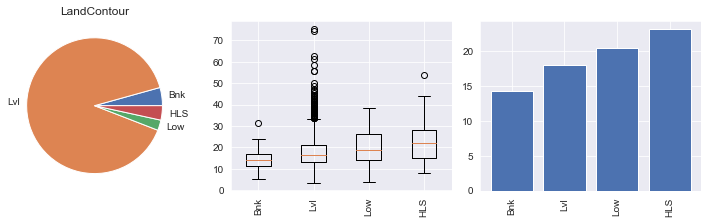

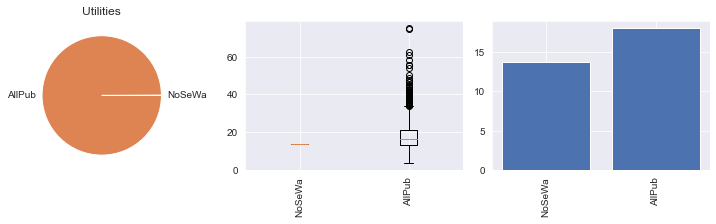

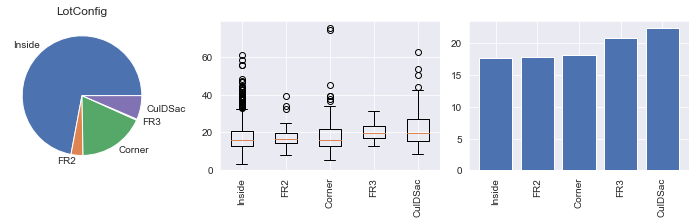

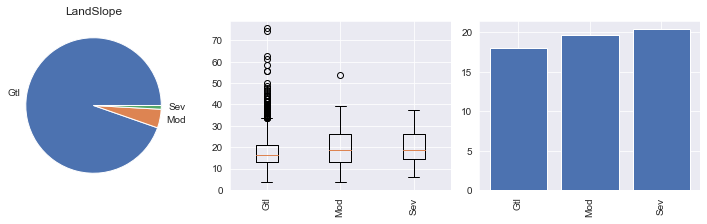

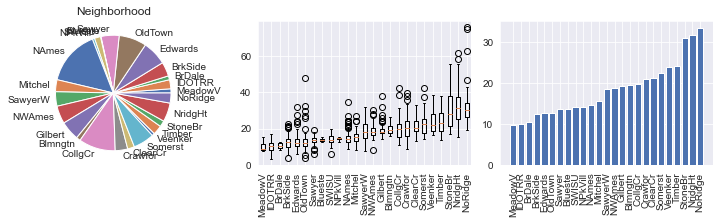

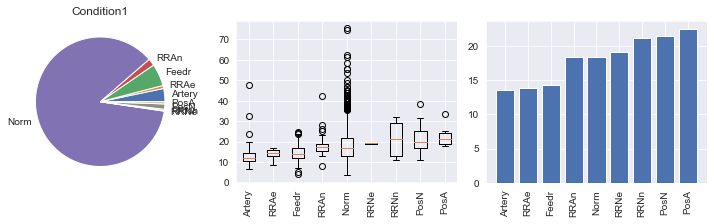

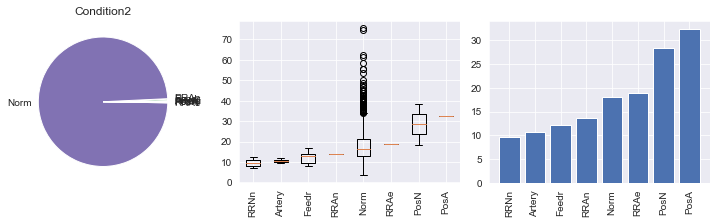

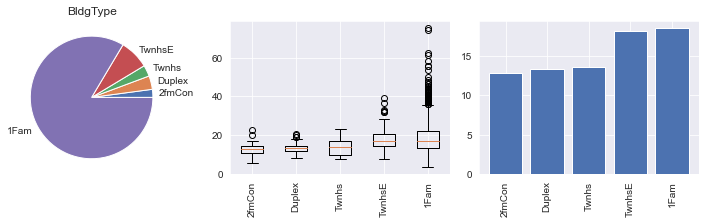

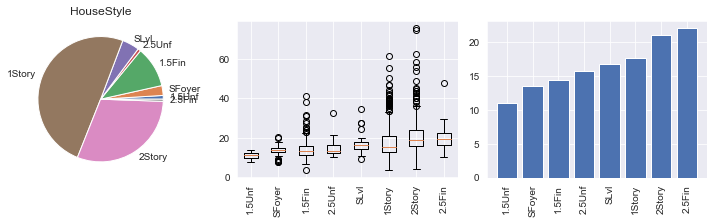

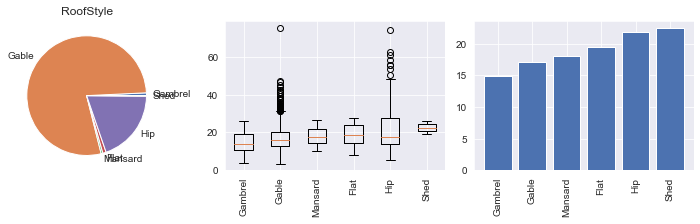

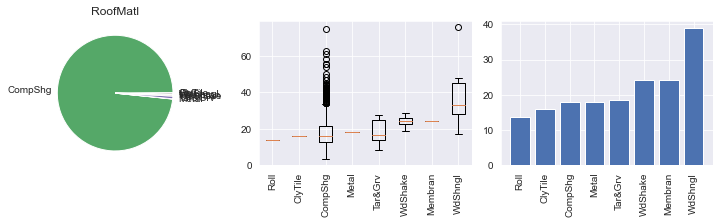

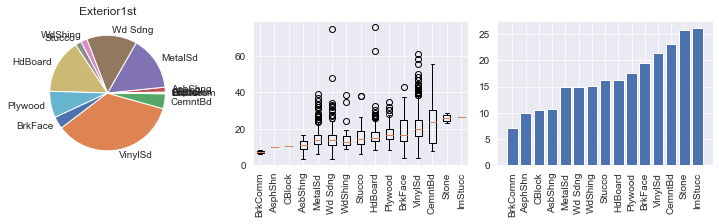

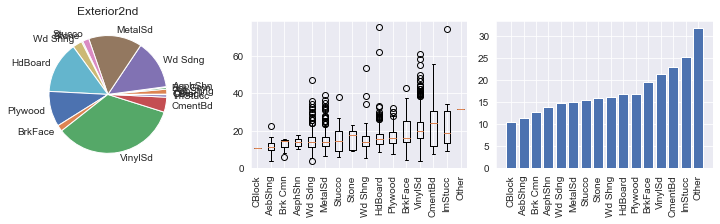

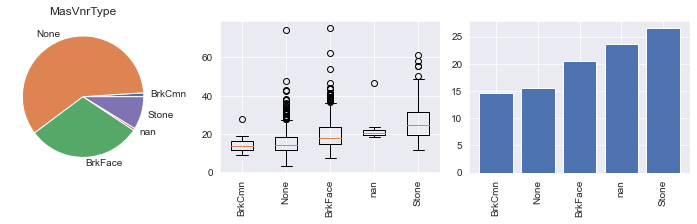

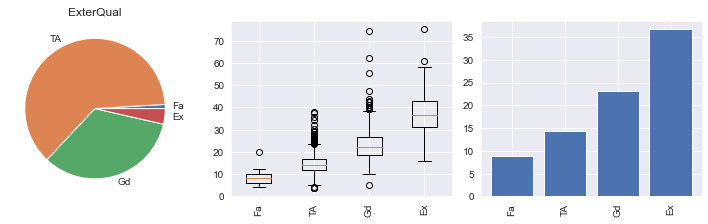

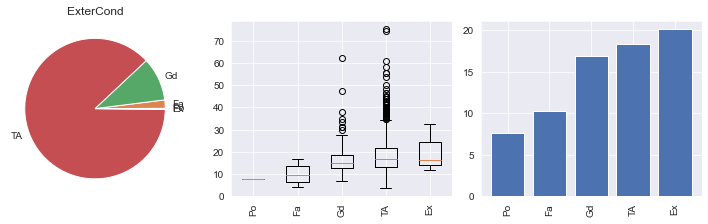

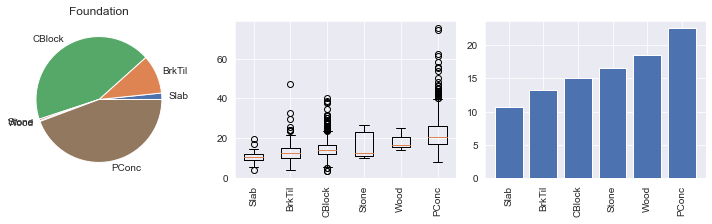

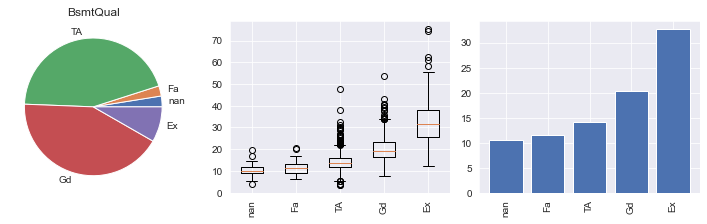

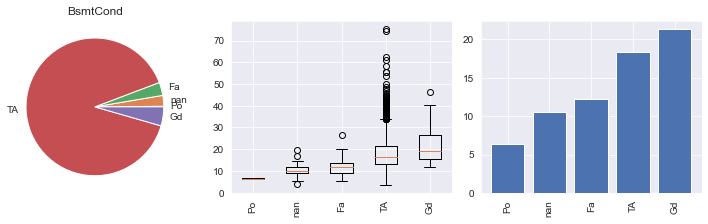

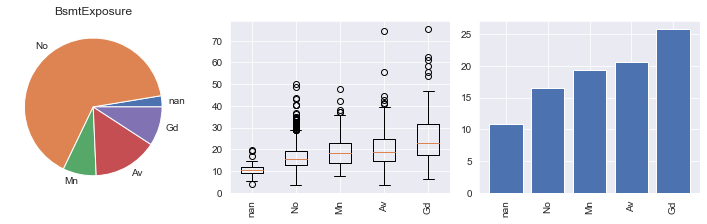

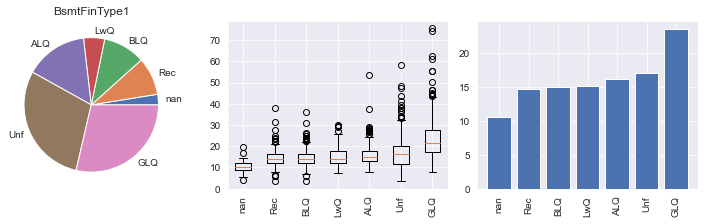

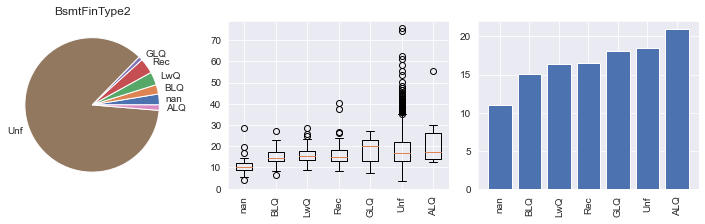

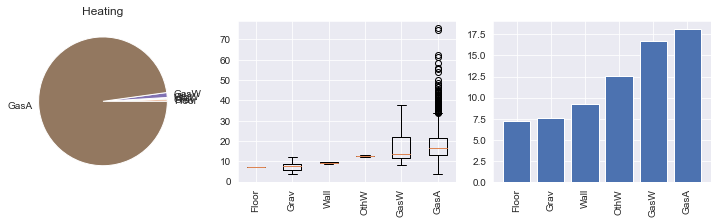

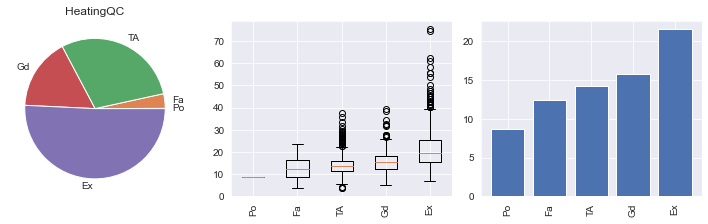

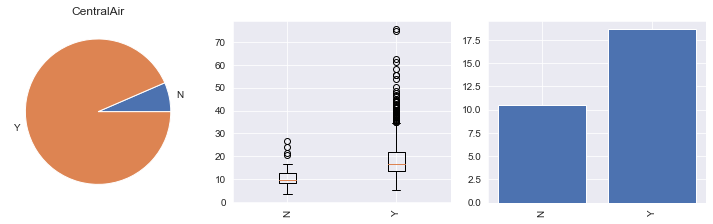

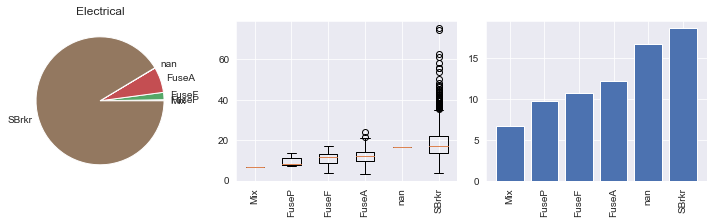

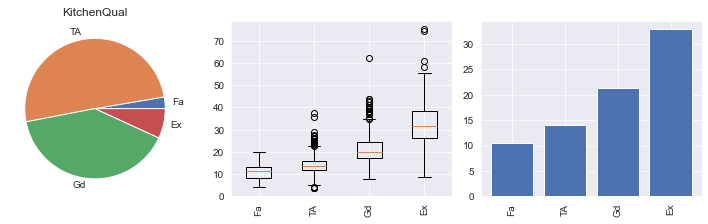

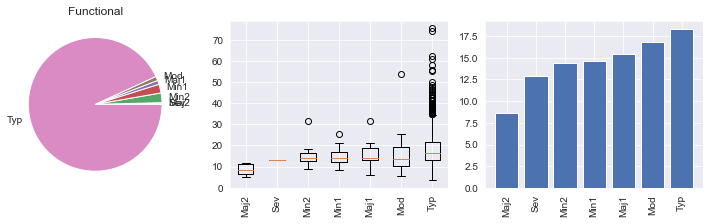

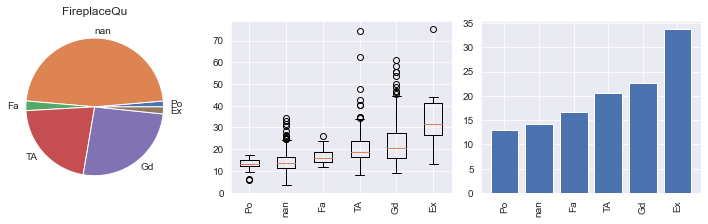

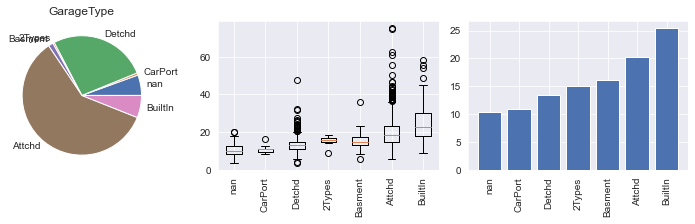

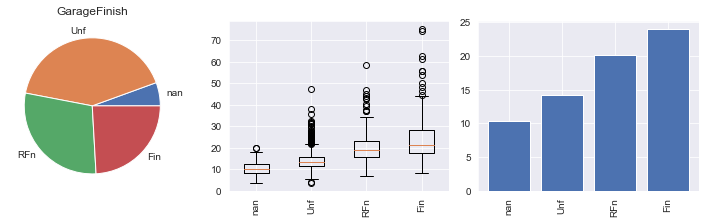

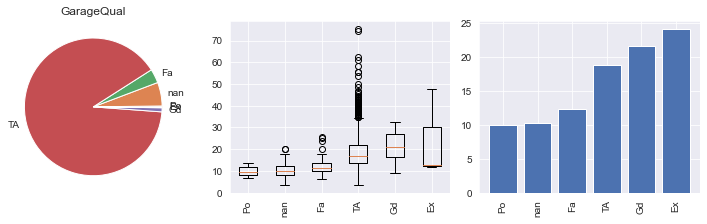

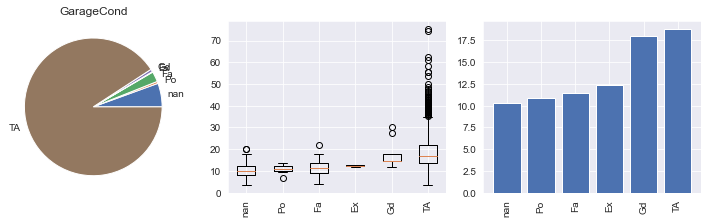

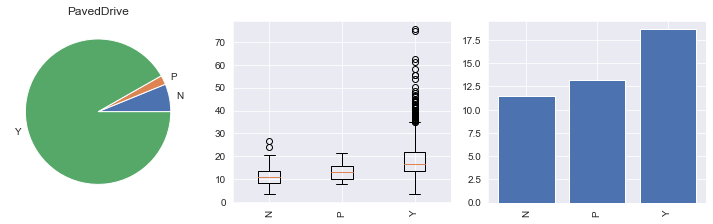

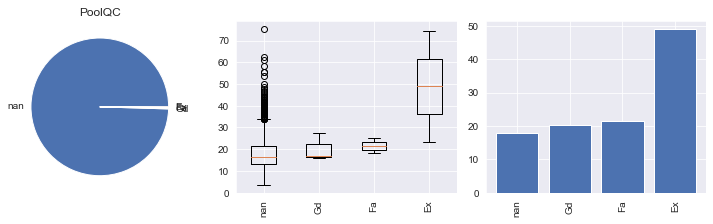

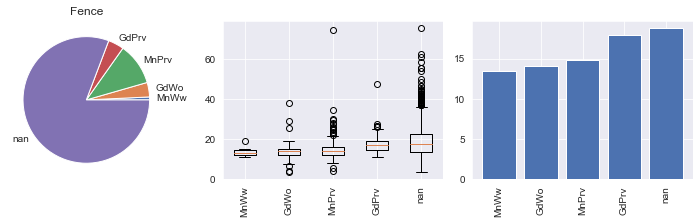

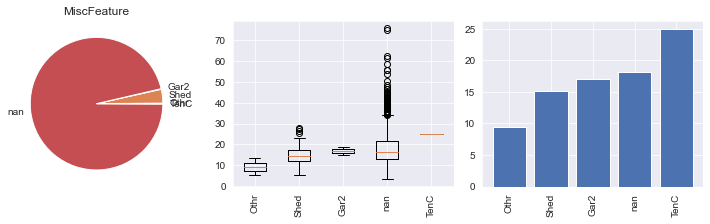

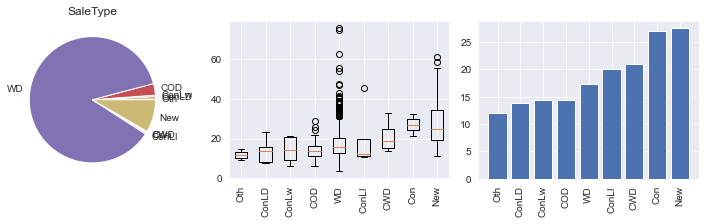

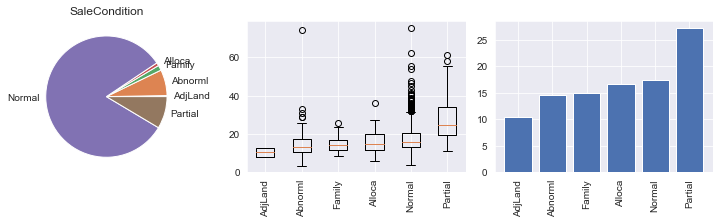

In [19]:
plot_cat(cat_cols)

Similar to the numerical columns
- Many of these features show a clear correlation with SalePrice
- For the most part the distribution of categories is not consistent, which is extreme in some cases like `Utilities`
- Exterior1st, Exteririor2nd, Neighbourhood, and MSSubClass (above) have many categories

There are two approaches to handle these features
1. Label Encoding
2. One-Hot-Encoding (Dummy Columns)

In order to reduce the number of fitting features, which can tend to lead to overfitting, we will encode the majority of the features with integers. One-Hot-Encoding can also lead to errors when categories in the test set are not present in the training set.

Based on modelling iteration, the Extract-Transform-Load pipeline also involves:
- `MSSubClass` is One-Hot-Encoded, with some additional code to ensure that all categories are present in the feature set, using the information in the `MSSubClass` entry in `data_description.txt`
- `MSZoning` had a negative impact upon model performance using both Label Encoding and One-Hot Encoding

In [20]:
cat_cols = [
    "ExterQual", "ExterCond", "BsmtCond", "BsmtQual", "GarageQual",
    "GarageCond", "HeatingQC", "KitchenQual", "FireplaceQu",
    "PoolQC", "Street", "Alley", "LotShape", "LandContour",
    "Condition1", "Condition2", "LandSlope", "BldgType", "MasVnrType",
    "Foundation", "BsmtExposure", "BsmtFinType1", "CentralAir",
    "RoofStyle", "GarageType", "GarageFinish", "PavedDrive", "Fence",
    "Neighborhood", "HouseStyle", "SaleType", "SaleCondition", "Electrical",
    "Exterior1st", "Exterior2nd", "Functional",
]

# Extract Transform Load

Based upon the above analysis we can create an Extract-Transform-Load pipeline to take the raw data and return the features and target variables.

The order of encoded labels is determined from the mean SalePrice in the training set. This encoding is stored in a dictionary that can then be applied to unlabeled data.

The category names for Exterior1st and Exterior2nd are standardised using a dictionary and `df.map`. This improves the performance slightly by combining a couple of the categories with very few examples and similar average SalesPrices  (AsbShng with AsphShn, and ImStucc with Other).

In [21]:
def ETL(filepath="train.csv", val_map=None, one_hot_cols=True):

    df = pd.read_csv(filepath, index_col="Id")

    # create a new dataframe with the desired features
    feat = df[bivariate_cols + year_cols + num_cat_cols + cat_cols].copy()

    # fill frontage null values with median values of similar buildings
    df["MSZoning"] = df["MSZoning"].fillna(df["MSZoning"].mode()[0])
    frontage_group = df.groupby(["Neighborhood", "MSZoning"])["LotFrontage"]
    feat["LotFrontage"] = frontage_group.transform(lambda x: x.fillna(x.mean()))

    # apply logarithmic correction to bivariate columns
    for col in bivariate_cols:
        with np.errstate(divide='ignore'):
            feat[col] = np.log(feat[col])
        feat.loc[feat[col] < 0, col] = np.nan

    # bin year columns by decade
    for year in year_cols:
        feat[year] = feat[year].fillna(0)
        feat[year] = feat[year].apply(lambda x: int(10 * np.round(float(x)/10)))

    feat.loc[feat["YearBuilt"] < 1920, "YearBuilt"] = 1920
    feat.loc[feat["GarageYrBlt"] < 1920, "GarageYrBlt"] = 1920

    # Encode & Map Categorical Columns
    extmap = {
        "AsbShng": "Asb",
        "AsphShn": "Asb",
        "BrkComm": "BrkComm",
        "Brk Cmn": "BrkComm",
        "BrkFace": "BrkFace",
        "CBlock": "CBlock",
        "CemntBd": "CemntBd",
        "CmentBd": "CmentBd",
        "HdBoard": "HdBoard",
        "ImStucc": "Other",
        "MetalSd": "MetalSd",
        "Other": "Other",
        "Plywood": "Plywood",
        "PreCast": "PreCast",
        "Stone": "Stone",
        "Stucco": "Stucco",
        "VinylSd": "VinylSd",
        "Wd Sdng": "WdSd",
        "Wd Shng": "WdSd",
        "WdShing": "WdSh",
    }

    feat["Exterior1st"] = feat["Exterior1st"].map(extmap)
    feat["Exterior2nd"] = feat["Exterior2nd"].map(extmap)

    if "SalePrice" in df:
        val_map = {}
        for col in cat_cols:
            vals = df.groupby(col, dropna=False)["SalePrice"].mean()
            vals = vals.sort_values().index.tolist()
            vals = dict(zip(vals, range(len(vals))))
            feat[col] = feat[col].map(vals)
            val_map[col] = vals
    else:
        for col in cat_cols:
            feat[col] = feat[col].map(val_map[col])

    # print columns that aren't included in the feature set
    # if "SalePrice" in df.columns:
    #    print("columns not included: ", [c for c in df.columns if c not in feat.columns])

    # One Hot Encode "MSSubClass" and make sure all columns are present
    if one_hot_cols:
        onehot = pd.get_dummies(df["MSSubClass"], prefix="MSSubClass")
        subclasses = [
            20, 30, 40, 45, 50, 60, 70, 75,
            80, 85, 90, 120, 150, 160, 180, 190
        ]
        for val in subclasses:
            if f"MSSubClass_{val}" not in onehot.columns:
                onehot[f"MSSubClass_{val}"] = 0
        feat = pd.merge(feat, onehot, right_index=True, left_index=True)

    # replace null values with zeros, as required for some regressor algorithms
    feat.fillna(0, inplace=True)

    # return SalePrice target if present in the dataset
    if "SalePrice" in df:
        return feat, df["SalePrice"], val_map
    return feat

## Correlation Map

Now we can use the ETL function to load the features, without the one-hot-encoded columns, to look at the correlation matrix including the target and features


Top 10 features by correlations with SalePrice
SalePrice       1.000000
OverallQual     0.790982
Neighborhood    0.696882
GrLivArea       0.695118
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
BsmtQual        0.622925
1stFlrSF        0.591264
FullBath        0.560664
GarageFinish    0.549247
YearBuilt       0.544571
TotRmsAbvGrd    0.533723
GarageYrBlt     0.529308
FireplaceQu     0.525932
YearRemodAdd    0.512119
Foundation      0.505503
Name: SalePrice, dtype: float64


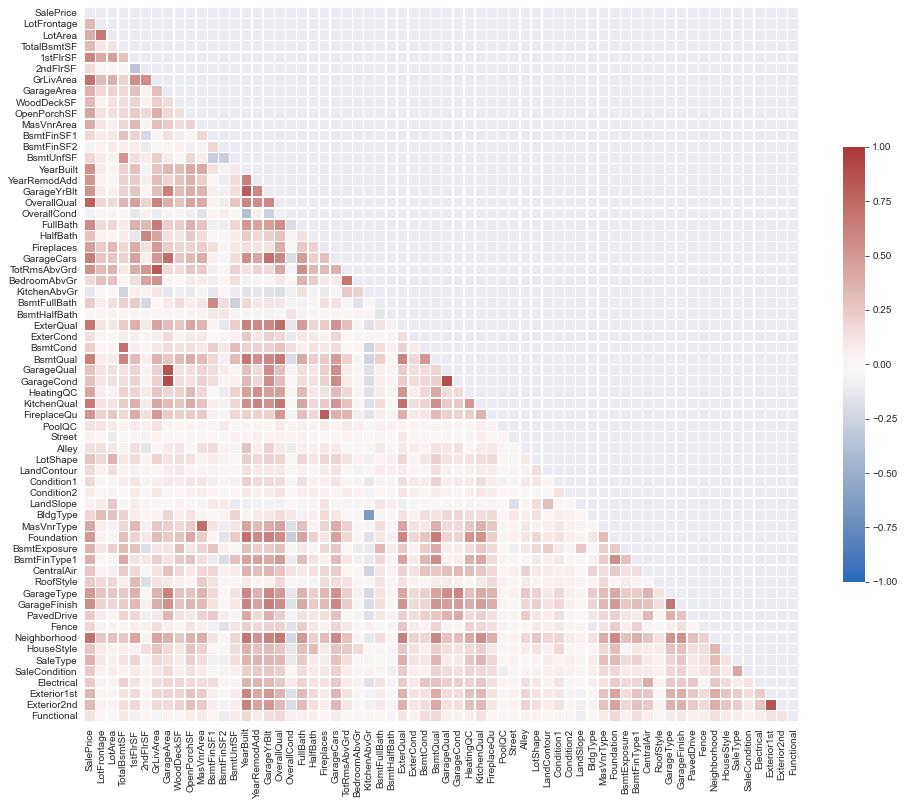

In [22]:
X, y, val_map = ETL(one_hot_cols=False)

covmat = pd.merge(y, X, right_index=True, left_index=True).corr()
mask = np.triu(np.ones_like(covmat, dtype=bool))
f, ax = plt.subplots(figsize=(16, 16))
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(covmat, mask=mask, cmap=cmap, center=0, vmin=-1, vmax=1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

print("Top 10 features by correlations with SalePrice")
print(covmat.loc[covmat["SalePrice"]>0.5, "SalePrice"].sort_values(ascending=False))

Here we can see that there is a strong correlation between quite a few of the features and the target.

Otherwise, as one might expect there is significant multicollinearity between features. In an ideal world this would not be the case as most regression algorithms assume independent variables.

# Modelling

## Train/Validation Split

First apply the standard approach and split off 20% of the training data for validation

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor

RANDOM_STATE = 4829  # ensure repeatable model iteration with a fixed seed

X, y, val_map = ETL()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

## Model Evaluation Function

The models will be evaluated on
- R2 score - standard scorer for regression models (1 = good)
- mean squared log error - what the competition is judged on (0 = good).
- plot ground truth vs predicted values. This will allows us to understand the issues affecting model performance

In [24]:
def evaluate_model(model, X_train, X_test, y_train, y_test):

    print(f"train: {model.score(X_train, y_train):.5f}", end=" ")
    print(f"test: {model.score(X_test, y_test):.5f}")

    print(f"train: {mean_squared_log_error(y_train, model.predict(X_train)):.6f}", end=" ")
    print(f"test: {mean_squared_log_error(y_test, model.predict(X_test)):.6f}")

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(y_train/10000, np.array(model.predict(X_train))/10000, 'o', mec="w", label="train")
    ax.plot(y_test/10000, np.array(model.predict(X_test))/10000, 'o', mec="w", label="test")
    ax.plot([0,80],[0, 80], color='k', lw=0.5)
    ax.set_xlabel("SalePrice Ground Truth x10000")
    ax.set_ylabel("Predictions x10000")
    ax.legend(loc=2)


## Ridge Regressor Baseline

As a baseline first we will model with a standard Ridge Regression algorithm, which implements L2-regularisation.

The `TransformedTargetRegressor` is used to handle the skewed target variable.

The model pipeline also includes the `StandardScaler` as a simple means of standardizing the features by removing the mean and scaling to unit variance `(z = (x - u) / s)`. Placing it in the pipeline ensures that data leakage does not happen later when we use cross-validation gridsearch for hyperparameter optimisation

train: 0.88080 test: 0.85153
train: 0.015124 test: 0.014038


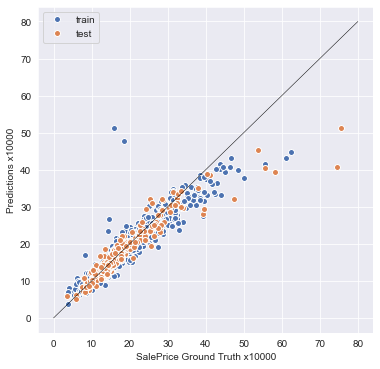

In [25]:
clf = Ridge(alpha=100)
tt = TransformedTargetRegressor(regressor=clf, func=np.log, inverse_func=np.exp)

model = Pipeline([
    ('sca', StandardScaler()),
    ('clf', tt)
])

model.fit(X_train, y_train)
evaluate_model(model, X_train, X_test, y_train, y_test)

Overall the performance isn't too bad even with the relatively simple Ridge regressor, with no signs of overfitting.

Ideally we would have a perfect 1:1 linear relationship between ground truth and predictions. As such we can identify the following issues:
1. The tendancy away from the linear relationship for the more expensive houses
2. The clear outliers where the prediction is far too large.
3. The variance along the diagonal in the linear region

We can try to identify the origin of the outliers, which is likely related to one or more of the stronger correlated features. Let's try `GrLivArea` (Above grade (ground) living area square feet)

prediction outliers indexes:  [1299, 524]


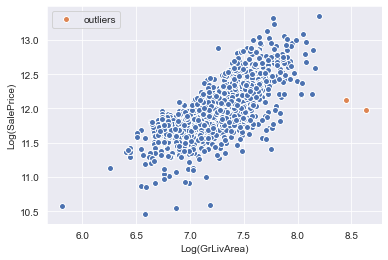

In [26]:
feats = pd.merge(y_train, X_train, left_index=True, right_index=True)
feats["preds"] = model.predict(X_train)
outliers = feats.loc[(feats["SalePrice"]<400000) & (feats["preds"]>400000)]
outliers = outliers.index.tolist()
print("prediction outliers indexes: ", outliers)

fig, ax = plt.subplots()
x, y = feats["GrLivArea"], np.log(feats["SalePrice"])

ax.plot(x, y, "o", mec="w")
ax.plot(x.loc[outliers], y.loc[outliers], "o", mec="w", label="outliers")
ax.set_xlabel("Log(GrLivArea)")
ax.set_ylabel("Log(SalePrice)")
_ = ax.legend()

There they are - very large houses that sold for far less than the average. Since we have already included most of the features from the original dataset, which could pinpoint the reason for the low sale price, a suitable next step will be to try a different algorithm, in this case XGBoost.

## XGBoost Regressor

Here we use XGBRegressor, which is an sklearn compatible class that works as a drop-in replacement for other scikit-learn models.

Let's first try it with the default hyperparameter values for regression problems, using `reg:squarederror` as the objective. The `tree_method` is set to the default `auto`, which chooses the most conservative option available. This was chosen primarily because it was the option used when developing this notebook offline.


train: 0.99973 test: 0.73271
train: 0.000051 test: 0.023544


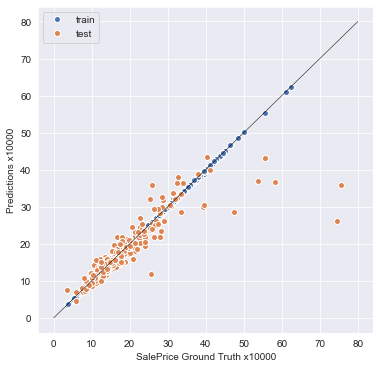

In [27]:
clf = XGBRegressor(
    objective="reg:squarederror",
    random_state=RANDOM_STATE,
)

tt = TransformedTargetRegressor(regressor=clf, func=np.log, inverse_func=np.exp)

model = Pipeline([
    ('sca', StandardScaler()),
    ('clf', tt)
])

model.fit(X_train, y_train)

evaluate_model(model, X_train, X_test, y_train, y_test)

We see an amazing fit on the training set, but the test set reveals severe overfitting.

To avoid overfitting, lets optimise the hyperparameters with a cross-validation grid search with suitable `max_depth`, `n_estimators` and `learning_rate` values.
- learning_rate: Step size shrinkage used in update to prevents overfitting
- max_depth: Maximum depth of a tree. Increasing this value will make the model more complex
- n_estimators: Number of boosting rounds
- colsample_bytree: Subsample ratio of columns when constructing each tree
- reg_lambda: L2 regularization term on weights (defaults to 1)

Optimised Parameters
clf__regressor__colsample_bytree: 0.7
clf__regressor__max_depth: 3
clf__regressor__n_estimators: 200
clf__regressor__reg_lambda: 1
train: 0.97425 test: 0.80038
train: 0.004680 test: 0.016805


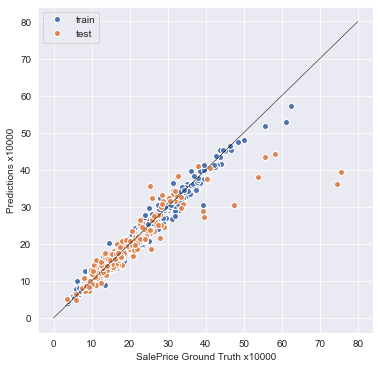

In [28]:
clf = XGBRegressor(
    objective="reg:squarederror",
    n_jobs=-1,
    learning_rate=0.1,
    random_state=RANDOM_STATE)

parameters = {
    "clf__regressor__max_depth": [2, 3],
    "clf__regressor__n_estimators": [50, 100, 200],
    "clf__regressor__colsample_bytree": [0.5, 0.7],
    "clf__regressor__reg_lambda": [0, 1],
}

tt = TransformedTargetRegressor(regressor=clf, func=np.log, inverse_func=np.exp)

pipeline = Pipeline([
    ('sca', StandardScaler()),
    ('clf', tt)
])

model = GridSearchCV(
    pipeline,
    param_grid=parameters,
    scoring="r2"
)

model.fit(X_train, y_train)

print("Optimised Parameters")
for k, v in model.best_params_.items():
    print(f"{k}: {v}")

evaluate_model(model, X_train, X_test, y_train, y_test)

With the optimised parameters we get a train/test score of 0.978 / 0.824, which based on these values alone looks like overfitting. However, looking at the graph we can see that variance in the linear region (where most of the examples lie) is comparable between the train and test sets, only failing with the high Sales Prices in the test set.

As such, we will take the best estimator and train it on the full training set before predicting the unlabeled data for submission.

train: 0.97118 test: 0.97464
train: 0.005449 test: 0.004936


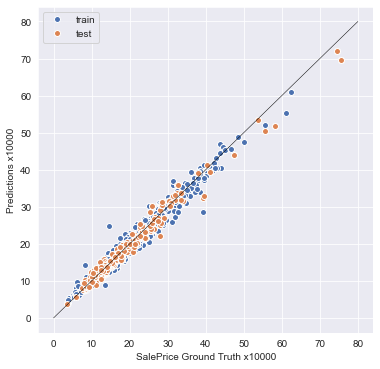

In [29]:
model = model.best_estimator_

X, y, val_map = ETL()

model.fit(X, y)
evaluate_model(model, X, X_test, y, y_test)

In [31]:
unlabeled = ETL("test.csv", val_map=val_map)
unlabeled["SalePrice"] = model.predict(unlabeled)
unlabeled["SalePrice"].to_csv("submission_5.csv")